**ライブラリのインポート**

In [312]:
import pandas as pd
from sklearn.impute import SimpleImputer  
import matplotlib.pyplot as plot
from feature_engine.imputation import EndTailImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, KBinsDiscretizer, MultiLabelBinarizer, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import time

**1. データの読み込みと簡単な解析**

In [267]:
data = pd.read_csv("/workspace/github_repo/data/covid_flu.csv")
data.head()

,Diagnosis,InitialPCRDiagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue
0,H1N1,NaN,67.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,No,NaN,38.111111,No
1,H1N1,NaN,29.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H1N1,NaN,22.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H1N1,NaN,20.0,F,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,Yes,Yes,NaN,No,NaN,36.555556,Yes
4,H1N1,NaN,21.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [268]:
data.describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,26.471040,6.854078,6.885159,1.850154,13.988506,38.068312
std,21.487982,12.690131,4.346668,3.956668,9.043171,1.094468
min,0.000000,0.446000,0.500000,0.130000,1.000000,35.722222
25%,7.000000,2.160000,3.995000,0.637500,7.000000,37.222222
50%,24.000000,3.310000,5.690000,0.905500,12.000000,38.000000
75%,42.000000,6.645000,9.155000,1.605000,20.000000,38.722222
max,88.000000,93.000000,36.070000,30.600000,37.000000,42.222222


In [269]:
data.isnull().mean()
#欠損値の割合

Diagnosis                      0.000000
InitialPCRDiagnosis            0.929825
Age                            0.018893
Sex                            0.051282
neutrophil                     0.930499
serumLevelsOfWhiteBloodCell    0.898111
lymphocytes                    0.894737
CReactiveProteinLevels         0.907557
DurationOfIllness              0.941296
CTscanResults                  0.892713
RiskFactors                    0.858974
GroundGlassOpacity             0.937247
Diarrhea                       0.696356
Fever                          0.377193
Coughing                       0.420378
ShortnessOfBreath              0.949393
SoreThroat                     0.547908
NauseaVomitting                0.715924
Temperature                    0.576248
Fatigue                        0.641700
dtype: float64

In [270]:
data["Diagnosis"].value_counts(normalize=True)
#目的変数の割合表示

Diagnosis
H1N1       0.723347
COVID19    0.276653
Name: proportion, dtype: float64

In [271]:
data.info()
#獲得特徴量の形式の確認

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Diagnosis                    1482 non-null   object 
 1   InitialPCRDiagnosis          104 non-null    object 
 2   Age                          1454 non-null   float64
 3   Sex                          1406 non-null   object 
 4   neutrophil                   103 non-null    float64
 5   serumLevelsOfWhiteBloodCell  151 non-null    float64
 6   lymphocytes                  156 non-null    float64
 7   CReactiveProteinLevels       137 non-null    object 
 8   DurationOfIllness            87 non-null     float64
 9   CTscanResults                159 non-null    object 
 10  RiskFactors                  209 non-null    object 
 11  GroundGlassOpacity           93 non-null     object 
 12  Diarrhea                     450 non-null    object 
 13  Fever             

**2. 量的データの欠損値の補完**

In [272]:
#量的データである列名
numeric_types = ['float16', 'float32', 'float64', 'int16', 'int32', 'int64']
numerical_columns = data.select_dtypes(include=numeric_types).columns.tolist()
numerical_columns

['Age',
 'neutrophil',
 'serumLevelsOfWhiteBloodCell',
 'lymphocytes',
 'DurationOfIllness',
 'Temperature']

In [273]:
#アプローチ1 : 平均値・中央値補完
num_impute = SimpleImputer(strategy='mean')  #平均値で補完する場合はmean 中央値の場合median
print(data['lymphocytes'].head())
result = num_impute.fit_transform(data[['lymphocytes']])   #ここで補完を行うが, 補完の結果numpyに変換されている
print(type(result))
print(result[:5])

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: lymphocytes, dtype: float64
<class 'numpy.ndarray'>
[[1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]]


In [274]:
#アプローチ2 : 任意値補完
arbitrary_impute = SimpleImputer(strategy="constant", fill_value=999) #モデルが欠損値であると判断しやすい値を選ぶこと
result = arbitrary_impute.fit_transform(data[['lymphocytes']]) #同様に補完を行う
print(type(result))
print(result[:5])

<class 'numpy.ndarray'>
[[999.]
 [999.]
 [999.]
 [999.]
 [999.]]


補完後タイプ :  <class 'pandas.core.frame.DataFrame'>


<Axes: title={'center': 'Lymphocytes (Imputed)'}, xlabel='cells/μL', ylabel='Frequency'>

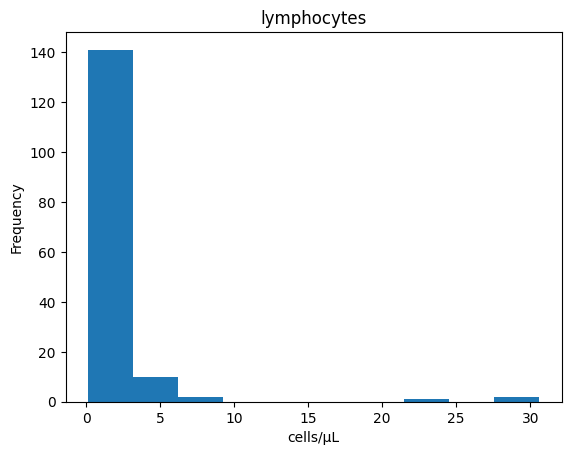

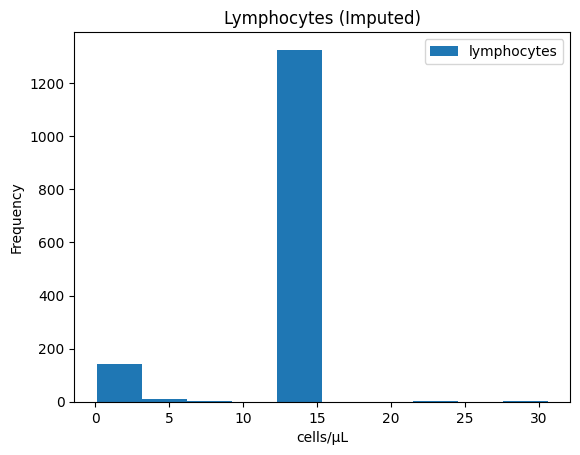

In [275]:
#アプローチ3 : 分布末尾補完 (任意値補完の補完値が自動的に分布の末尾となるようになるようにした補完手法)

#まずは補完前の「lymphpcytes」のヒストグラムの表示
data["lymphocytes"].plot(title="lymphocytes", kind="hist", xlabel="cells/μL")
#補完の実行
result = EndTailImputer().fit_transform(data[['lymphocytes']])
print("補完後タイプ : ", type(result))
#補完後のヒストグラム表示
result.plot(
    title='Lymphocytes (Imputed)', kind='hist', xlabel='cells/μL'
)

**3. 質的データの欠損値の補完手法について**

In [276]:
#質的特徴量の表示
categolical_columns = data.select_dtypes(include=["object"]).columns.to_list()
categolical_columns.remove("Diagnosis")
for col in categolical_columns:
    print("=======")
    print(col)
    print("-------")
    print(data[col].value_counts(dropna=False), "\n")

# RiskFactorsの列はかなり多い変数を取るが, それ以外はほとんど2値だとわかる

InitialPCRDiagnosis
-------
InitialPCRDiagnosis
NaN    1378
Yes     100
No        4
Name: count, dtype: int64 

Sex
-------
Sex
M      748
F      658
NaN     76
Name: count, dtype: int64 

CReactiveProteinLevels
-------
CReactiveProteinLevels
NaN           1345
8                3
0.5              3
15               3
111              2
              ... 
5.78             1
67.62            1
13.2 mg/dL       1
21.27            1
0.6              1
Name: count, Length: 121, dtype: int64 

CTscanResults
-------
CTscanResults
NaN    1323
Yes     144
No       15
Name: count, dtype: int64 

RiskFactors
-------
RiskFactors
NaN                                                                   1273
asthma                                                                  36
pneumonia                                                               21
immuno                                                                  21
diabetes                                                                16


In [277]:
#"Sex"列をF,M表記からTrue,False表記に変換
data["Female"] = data["Sex"] == "F"
data = data.drop(["Sex"], axis=1)
#Yes,Noの2値を取る質的変数について0,1変換
data = data.replace({"Yes":True, "No":False})
data.head()

,Diagnosis,InitialPCRDiagnosis,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue,Female
0,H1N1,NaN,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,False,NaN,38.111111,False,True
1,H1N1,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,H1N1,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,H1N1,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,True,True,NaN,False,NaN,36.555556,True,True
4,H1N1,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [278]:
#質的変数の欠損値補完(3つのアプローチが存在)
#アプローチ1 : 最頻カテゴリー補完
print(data['Coughing'].head())
cat_impute = SimpleImputer(strategy='most_frequent')
result = cat_impute.fit_transform(data[['Coughing']])[:5]
print("補完後タイプ : ", type(result)) #Numpyに変換される
print(result)

0    True
1     NaN
2     NaN
3    True
4     NaN
Name: Coughing, dtype: object
補完後タイプ :  <class 'numpy.ndarray'>
[[True]
 [True]
 [True]
 [True]
 [True]]


In [279]:
#アプローチ2 : 任意カテゴリー補完
columns_dict = data.nunique().to_dict()
binary_features = [key for key, value in columns_dict.items() if value==2]
binary_features.remove("Diagnosis")
print(binary_features) #2値のみを取る変数を抽出
fill_with_false = SimpleImputer(strategy="constant", fill_value=False)
result = fill_with_false.fit_transform(data[binary_features])
print(result)

['InitialPCRDiagnosis', 'CTscanResults', 'GroundGlassOpacity', 'Diarrhea', 'Fever', 'Coughing', 'ShortnessOfBreath', 'SoreThroat', 'NauseaVomitting', 'Fatigue', 'Female']
[[False False False ... False False True]
 [False False False ... False False False]
 [False False False ... False False True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


**特徴量(数値)のスケーリング手法について**

In [280]:
#Min-Maxスケーリング
result = pd.DataFrame(MinMaxScaler().fit_transform(data[numerical_columns]), columns=numerical_columns)
result.describe()


,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,0.300807,0.069236,0.179510,0.056454,0.360792,0.360937
std,0.244182,0.137111,0.122200,0.129855,0.251199,0.168380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.079545,0.018519,0.098257,0.016656,0.166667,0.230769
50%,0.272727,0.030944,0.145909,0.025451,0.305556,0.350427
75%,0.477273,0.066977,0.243323,0.048408,0.527778,0.461538
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [281]:
#Z-scoreスケーリング
result = pd.DataFrame(StandardScaler().fit_transform(data[numerical_columns]), columns=numerical_columns)
result.describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1.454000e+03,103.000000,1.510000e+02,1.560000e+02,8.700000e+01,6.280000e+02
mean,1.954726e-17,0.000000,-1.411674e-16,-1.708035e-17,-5.614921e-17,1.708471e-15
std,1.000344e+00,1.004890,1.003328e+00,1.003221e+00,1.005797e+00,1.000797e+00
min,-1.232324e+00,-0.507435,-1.473866e+00,-4.361482e-01,-1.444604e+00,-2.145299e+00
25%,-9.064480e-01,-0.371709,-6.671264e-01,-3.074706e-01,-7.772737e-01,-7.736770e-01
50%,-1.150359e-01,-0.280644,-2.758748e-01,-2.395187e-01,-2.211651e-01,-6.246559e-02
75%,7.229298e-01,-0.016556,5.239403e-01,-6.215921e-02,6.686088e-01,5.979450e-01
max,2.864398e+00,6.821614,6.736646e+00,7.289577e+00,2.559378e+00,3.798396e+00


**4.1 数値特徴量の作成について**

対数変換

<Axes: title={'center': 'Lymphocytes'}, xlabel='cells/μL', ylabel='Frequency'>

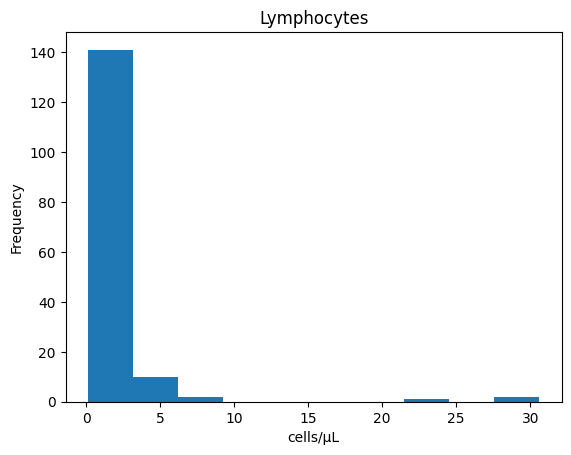

In [282]:
#対数変換
data['lymphocytes'].plot(
    title='Lymphocytes', kind='hist', xlabel='cells/μL'
)  # 対数変換前

<Axes: title={'center': 'Lymphocytes (Log Transformed)'}, xlabel='cells/μL', ylabel='Frequency'>

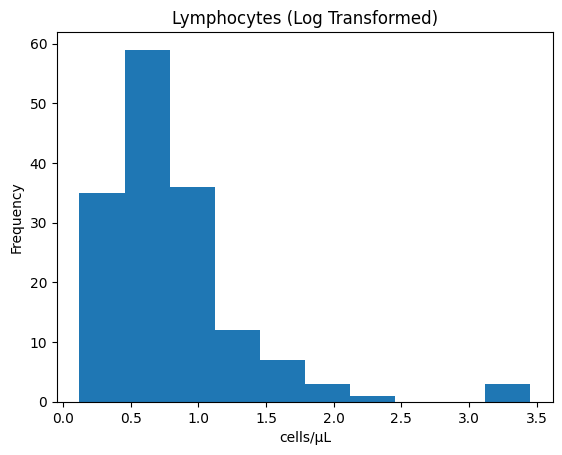

In [283]:
data['lymphocytes'].map(np.log1p).plot(
    title='Lymphocytes (Log Transformed)', kind='hist', xlabel='cells/μL'
)  # 対数変換後 (やや正規分布に近付いていることが確認できる)

Box-Cox変換

In [284]:
#Box-Cox変換では正の値しか機能しないため0.01を加算する
data['Age'] = data['Age'] + 0.01

λ値 :  [ 0.4103525  -0.22261794  0.12473205 -0.24415703  0.36376998 -7.01162899]


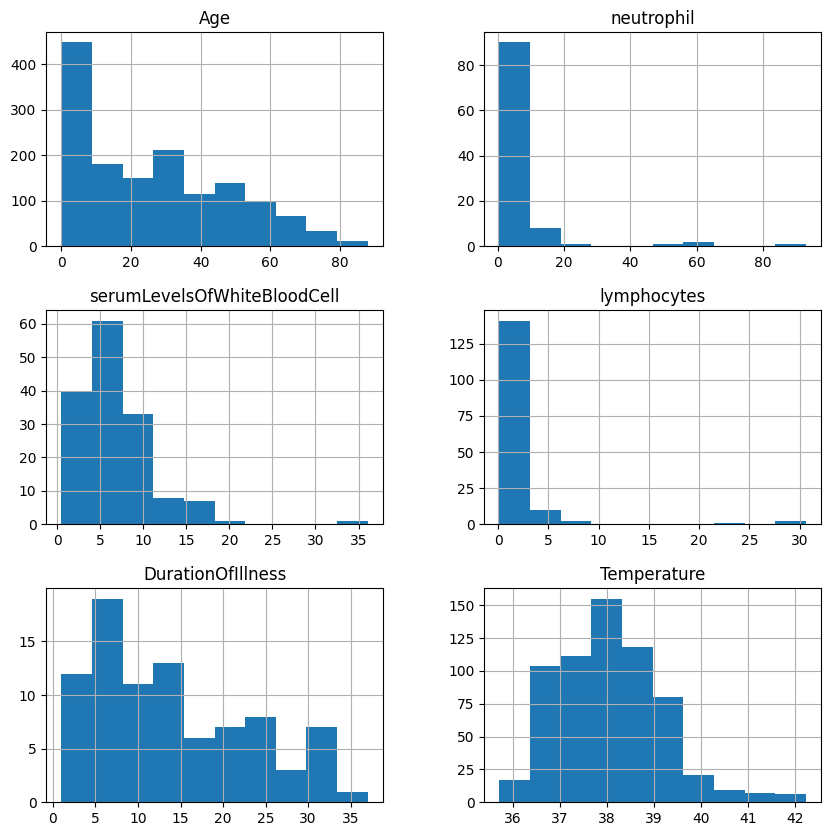

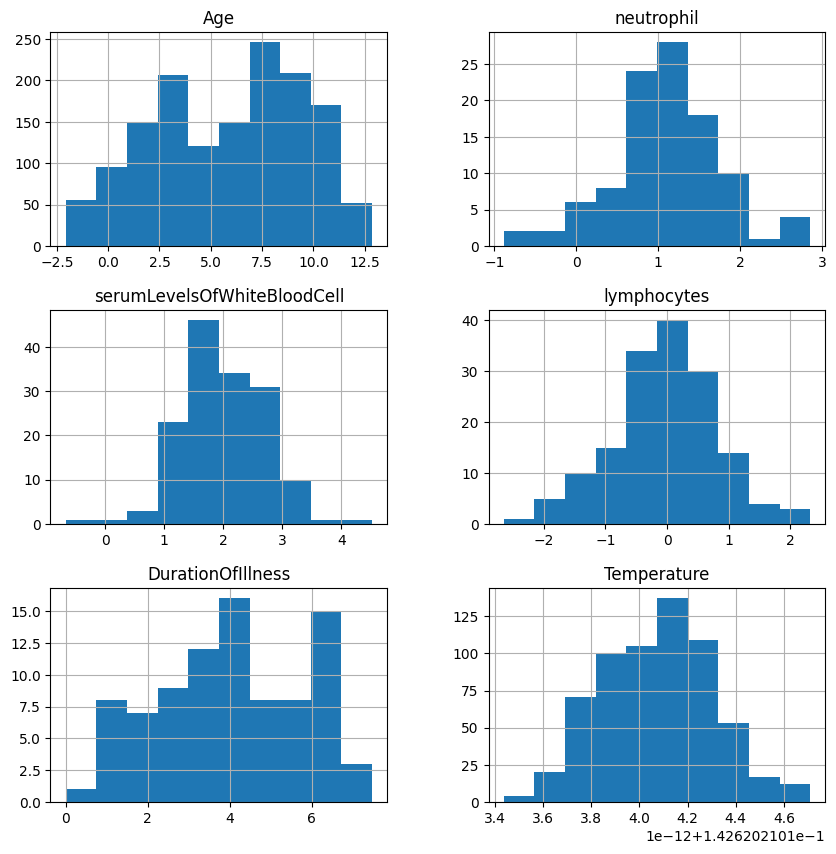

In [285]:
boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)
pd.DataFrame(data[numerical_columns]).hist(figsize=(10, 10))

pd.DataFrame(
    boxcox_transformer.fit_transform(data[numerical_columns]), 
    columns=numerical_columns
).hist(figsize=(10, 10))
print("λ値 : ", boxcox_transformer.lambdas_)

**4.2 カテゴリー特徴量の作成について**

ビニング(カテゴリー特徴量 or 量的特徴量 → カテゴリー特徴量)

[[2.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


<Axes: title={'center': 'Age (Uniform Binning)'}, xlabel='Age', ylabel='Frequency'>

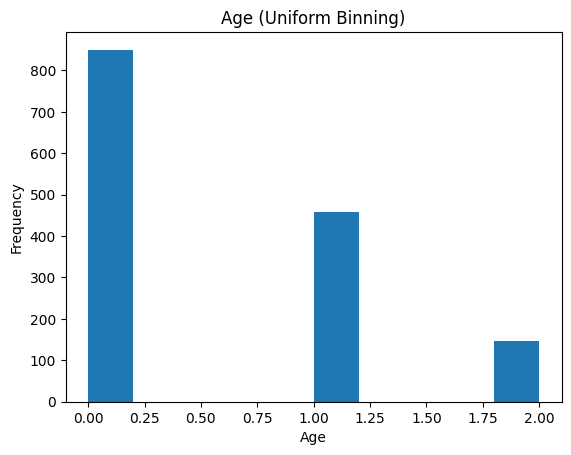

In [286]:
#3つのアプローチが存在
#アプローチ1 : 均一ビニング(等間隔で分割)
binner = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform")
binned_data = binner.fit_transform(data[["Age"]].dropna())
print(binned_data)
pd.Series(binned_data.reshape(-1,)).plot(title="Age (Uniform Binning)", kind="hist", xlabel="Age")

[[2.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


<Axes: title={'center': 'Age (Quantile Binning)'}, xlabel='Age', ylabel='Frequency'>

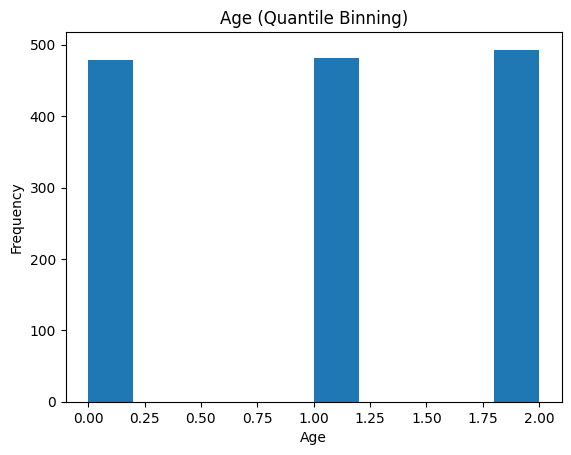

In [287]:
#アプローチ2 : 均一ビニング(等量で分割)
binner = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
binned_data = binner.fit_transform(data[["Age"]].dropna())
print(binned_data)
pd.Series(binned_data.reshape(-1,)).plot(title="Age (Quantile Binning)", kind="hist", xlabel="Age")

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


[[2.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


<Axes: title={'center': 'Age (Kmeans Binning)'}, xlabel='Age', ylabel='Frequency'>

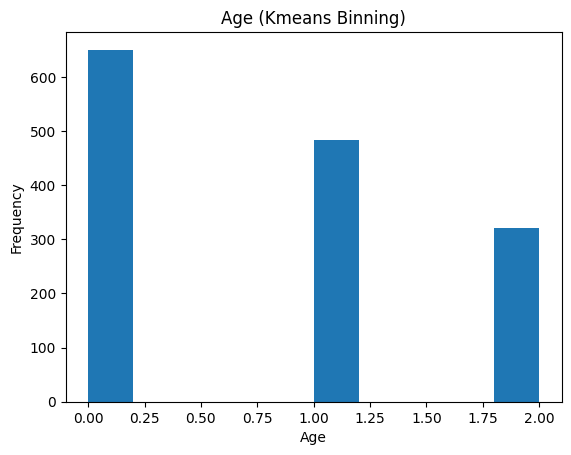

In [288]:
#アプローチ3 : k-meansビニング(k-meansクラスタリングで分割)
binner = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="kmeans")
binned_data = binner.fit_transform(data[["Age"]].dropna())
print(binned_data)
pd.Series(binned_data.reshape(-1,)).plot(title="Age (Kmeans Binning)", kind="hist", xlabel="Age")

one-hot encoding(カテゴリー特徴量 → カテゴリー特徴量(モデルが解釈できる形))

In [289]:
#今回のRsikFactors専用の変換機を作成

class DummifyRiskFactor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_binarizer = None

    def parse_risk_factors(self, comma_sep_factors):
        '''asthma,heart disease -> ['asthma', 'heart disease']'''
        try:
            return [s.strip().lower() for s in comma_sep_factors.split(",")]
        except:
            return []
    
    def fit(self, X, y=None):
        self.label_binarizer = MultiLabelBinarizer()
        self.label_binarizer.fit(X.apply(self.parse_risk_factors))
        return self
    
    def transform(self, X, y=None):
        return self.label_binarizer.transform(X.apply(self.parse_risk_factors))


In [290]:
#変換機を実際に使用
drf = DummifyRiskFactor()
risks = drf.fit_transform(data["RiskFactors"])
risk_df = pd.DataFrame(risks, columns=drf.label_binarizer.classes_)
risk_df.head()

,asthma,athero,atopic dermatitis and repetitive respiratory infections,begin tumor (removed),chronic,chronic endrocrine disorder,chronic liver dieseas,chronic liver disorder,chronic neurological disorders,chronic obstructive pulmonary disease,...,lung disease,myxoma of abdominal cavity,obesity,pneumomediastinum and subcutaneous emphysema,pneumonia,pre-eclampsia,prom,renal disease,respiratory disease,rheumatoid arthritis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ドメイン特徴量(ドメイン知識を使った新しい特徴量の作成)

In [291]:
#新しい特徴量として「FluSymptom : インフルエンザの症状のうち, 2つ以上を満たしているかのbool値」を作成する
data['FluSymptoms'] = data[['Diarrhea', 'Fever', 'Coughing', 'SoreThroat', 'NauseaVomitting', 'Fatigue']].sum(axis=1) >= 2
print(data['FluSymptoms'].value_counts())
print("データ欠損数 : ", data['FluSymptoms'].isnull().sum())

FluSymptoms
False    753
True     729
Name: count, dtype: int64
データ欠損数 :  0


**5. 特徴量エンジニアリングパイプラインの構築**

グリッドサーチを行い, 決定木を学習し結果を表示するパイプラインのテンプレート関数の定義

In [292]:
def simple_grid_search(x_train, y_train, x_test, y_test, FE_pipeline): #FE = Feature Engineering
    params = {
        "max_depth" : [10,None],
        "n_estimators" : [10,50,100,500],
        "criterion" : ["gini", "entropy"]
    }
    base_model = ExtraTreesClassifier()
    grid_searcher = GridSearchCV(base_model, param_grid=params, cv=3)
    
    start_time = time.time()
    if FE_pipeline:
        parsed_xtrain = FE_pipeline.fit_transform(x_train, y_train)
        parsed_xtest = FE_pipeline.transform(x_test)
    else:
        parsed_xtrain = x_train
        parsed_xtest = x_test
    parse_time = time.time()
    print(f"Parsing time : {parse_time-start_time}")

    grid_searcher.fit(parsed_xtrain, y_train)
    fit_time = time.time()
    print(f"Training time : {fit_time-start_time}")

    best_model = grid_searcher.best_estimator_

    print(classification_report(y_true=y_test, y_pred=best_model.predict(parsed_xtest)))
    end_time = time.time()
    print(f"Overall time : {end_time-start_time}\n")

    return best_model

学習データの分割

In [293]:
X, y = data.drop(["Diagnosis"], axis=1), data["Diagnosis"]
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)

これまでで作成した各種特徴量エンジニアリングを適用するパイプラインの定義

In [294]:
# リスク要因を処理するパイプライン
risk_factor_pipeline = Pipeline(
    [
        ("select_and_parse_risk_factor", FunctionTransformer(lambda df:df["RiskFactors"])),
        ("dummify", DummifyRiskFactor())
    ]
)

#2値のカテゴリー変数を補完する変換するパイプライン
binary_pipeline = Pipeline(
    [
        ("select_categorical_features", FunctionTransformer(lambda df:df[binary_features])),
        ("fillna", SimpleImputer(strategy="constant", fill_value=False))
    ]
)

#量的変数を補完するパイプライン
numerical_pipeline = Pipeline(
    [
        ("select_numerical_features", FunctionTransformer(lambda df:df[numerical_columns])),
        ("impute", SimpleImputer(strategy="median"))
    ]
)

各種パイプラインを与えた際のそれぞれの学習結果

In [295]:
simple_grid_search(x_train, y_train, x_test, y_test, risk_factor_pipeline)
simple_grid_search(x_train, y_train, x_test, y_test, binary_pipeline)
simple_grid_search(x_train, y_train, x_test, y_test, numerical_pipeline)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.003457307815551758


Training time : 3.6962878704071045
              precision    recall  f1-score   support

     COVID19       0.80      0.10      0.17        82
        H1N1       0.74      0.99      0.85       215

    accuracy                           0.74       297
   macro avg       0.77      0.54      0.51       297
weighted avg       0.76      0.74      0.66       297

Overall time : 3.7018275260925293

Parsing time : 0.003390073776245117
Training time : 3.6728034019470215
              precision    recall  f1-score   support

     COVID19       0.82      0.62      0.71        82
        H1N1       0.87      0.95      0.91       215

    accuracy                           0.86       297
   macro avg       0.85      0.79      0.81       297
weighted avg       0.86      0.86      0.85       297

Overall time : 3.6811206340789795

Parsing time : 0.0027251243591308594
Training time : 4.083220958709717
              precision    recall  f1-score   support

     COVID19       0.78      0.72      0.75 

ExtraTreesClassifier()

各種パイプラインを連結した場合の学習結果

In [297]:
simple_fe = FeatureUnion([ #パイプラインを1つにまとめる
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline)
])
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe)
#前と比べると正答率は大きく上昇(0.92)している

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.02116084098815918
Training time : 4.936810493469238
              precision    recall  f1-score   support

     COVID19       0.85      0.84      0.85        82
        H1N1       0.94      0.94      0.94       215

    accuracy                           0.92       297
   macro avg       0.90      0.89      0.89       297
weighted avg       0.92      0.92      0.92       297

Overall time : 4.946187973022461



平均値補完を試した場合の学習結果

In [299]:
numerical_pipeline_2 = Pipeline( #平均値補完に変更
    [
        ("select_numerical_features", FunctionTransformer(lambda df:df[numerical_columns])),
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler())
    ]
)
simple_fe_2 = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline_2)
])
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe_2)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.0203855037689209
Training time : 4.900030612945557
              precision    recall  f1-score   support

     COVID19       0.87      0.84      0.86        82
        H1N1       0.94      0.95      0.95       215

    accuracy                           0.92       297
   macro avg       0.91      0.90      0.90       297
weighted avg       0.92      0.92      0.92       297

Overall time : 4.9254961013793945



任意値補完を適用した場合

In [300]:
numerical_pipeline_3 = Pipeline( #任意値補完に変更
    [
        ("select_numerical_features", FunctionTransformer(lambda df:df[numerical_columns])),
        ("impute", SimpleImputer(strategy="constant", fill_value=999)),
        ("scale", StandardScaler())
    ]
)
simple_fe_3 = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline_3)
])
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe_3)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.017113447189331055
Training time : 4.66486120223999
              precision    recall  f1-score   support

     COVID19       0.89      0.87      0.88        82
        H1N1       0.95      0.96      0.95       215

    accuracy                           0.93       297
   macro avg       0.92      0.91      0.92       297
weighted avg       0.93      0.93      0.93       297

Overall time : 4.6742963790893555



分布末尾補完とBox-Cox変換を併用した場合

In [301]:
numerical_pipeline_4 = Pipeline(
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('box-cox', PowerTransformer(method='box-cox', standardize=True)),
        ('turn_into_df', FunctionTransformer(lambda matrix: pd.DataFrame(matrix))), 
        ('end_of_tail', EndTailImputer(imputation_method='gaussian'))
    ]
)

simple_fe_4 = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline_4)
])

best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe_4)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.02948451042175293
Training time : 5.295811653137207
              precision    recall  f1-score   support

     COVID19       0.81      0.84      0.83        82
        H1N1       0.94      0.93      0.93       215

    accuracy                           0.90       297
   macro avg       0.88      0.88      0.88       297
weighted avg       0.90      0.90      0.90       297

Overall time : 5.320462703704834



ビニングを適用した場合

In [302]:
numerical_pipeline_5 = Pipeline(
    [
        ('select_numerical_features', FunctionTransformer(lambda df: df[numerical_columns])),
        ('box-cox', PowerTransformer(method='box-cox', standardize=True)),
        ('turn_into_df', FunctionTransformer(lambda matrix: pd.DataFrame(matrix))),
        ('end_of_tail', EndTailImputer(imputation_method='gaussian')),
        ('ordinal_bins', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans'))
    ]
)

simple_fe_5 = FeatureUnion([
    ('risk_factors', risk_factor_pipeline),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline_5)
])

best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe_5)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.04536104202270508
Training time : 5.094884634017944
              precision    recall  f1-score   support

     COVID19       0.85      0.80      0.82        82
        H1N1       0.93      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.87      0.88       297
weighted avg       0.90      0.91      0.90       297

Overall time : 5.104063987731934



**6. 特徴量選択**

*リスクファクターに関する特徴量はone-hotエンコーディングによって次元数がかなり多く疎なデータであるため

相互情報量を用いた選択

In [306]:
risk_factor_pipeline_2 = Pipeline(  # add feature selection
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor()),
        ('mutual_info', SelectKBest(mutual_info_classif, k=20)),  #特徴量選択
    ]
)

simple_fe_6 = FeatureUnion([
    ('risk_factors', risk_factor_pipeline_2),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline_5)
])

best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe_6)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.11648297309875488
Training time : 4.5188963413238525
              precision    recall  f1-score   support

     COVID19       0.86      0.82      0.84        82
        H1N1       0.93      0.95      0.94       215

    accuracy                           0.91       297
   macro avg       0.90      0.88      0.89       297
weighted avg       0.91      0.91      0.91       297

Overall time : 4.52796483039856



カイニ乗検定を用いた選択

In [310]:
risk_factor_pipeline_3 = Pipeline(
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor()),
        ('chi2', SelectKBest(chi2, k=10))  #特徴量選択
    ]
)

simple_fe_7 = FeatureUnion([
    ('risk_factors', risk_factor_pipeline_3),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline_5)
])

best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe_7)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.05280351638793945
Training time : 4.644176721572876
              precision    recall  f1-score   support

     COVID19       0.87      0.80      0.84        82
        H1N1       0.93      0.95      0.94       215

    accuracy                           0.91       297
   macro avg       0.90      0.88      0.89       297
weighted avg       0.91      0.91      0.91       297

Overall time : 4.653013706207275



決定木の特徴量重要度を用いて特徴量選択を行う

In [315]:
risk_factor_pipeline_3 = Pipeline(
    [
        ('select_risk_factor', FunctionTransformer(lambda df: df['RiskFactors'])),
        ('dummify', DummifyRiskFactor()),
        ('tree_selector', SelectFromModel(max_features=20, estimator=DecisionTreeClassifier())) #特徴量選択
    ]
)

simple_fe_8 = FeatureUnion([
    ('risk_factors', risk_factor_pipeline_3),
    ('binary_pipeline', binary_pipeline),
    ('numerical_pipeline', numerical_pipeline_5)
])

# let's stop here
best_model = simple_grid_search(x_train, y_train, x_test, y_test, simple_fe_8)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['atopic dermatitis and repetitive respiratory infections', 'begin tumor (removed)', 'chronic liver disorder', 'chronic neurological disorders', 'fatty liver', 'hypertention', 'lung disease', 'pneumomediastinum and subcutaneous emphysema', 'rheumatoid arthritis'] will be ignored
  warnings.warn(


Parsing time : 0.048766136169433594
Training time : 4.586491107940674
              precision    recall  f1-score   support

     COVID19       0.85      0.82      0.83        82
        H1N1       0.93      0.94      0.94       215

    accuracy                           0.91       297
   macro avg       0.89      0.88      0.88       297
weighted avg       0.91      0.91      0.91       297

Overall time : 4.595502853393555



**疑問点**  
なぜか触れられていないが「CReactiveProteinLevels」に関しては単位があったりなかったりで数値データのはずがカテゴリーデータになっている気がする  
もしかするとあまりに欠損値が多いので無視する方針なのかもしれない


In [321]:
data.dtypes

Diagnosis                       object
InitialPCRDiagnosis             object
Age                            float64
neutrophil                     float64
serumLevelsOfWhiteBloodCell    float64
lymphocytes                    float64
CReactiveProteinLevels          object
DurationOfIllness              float64
CTscanResults                   object
RiskFactors                     object
GroundGlassOpacity              object
Diarrhea                        object
Fever                           object
Coughing                        object
ShortnessOfBreath               object
SoreThroat                      object
NauseaVomitting                 object
Temperature                    float64
Fatigue                         object
Female                            bool
FluSymptoms                       bool
dtype: object

In [322]:
data["CReactiveProteinLevels"].value_counts()

CReactiveProteinLevels
8             3
0.5           3
15            3
34.64         2
5.6           2
             ..
8.88          1
5.78          1
67.62         1
13.2 mg/dL    1
0.6           1
Name: count, Length: 120, dtype: int64